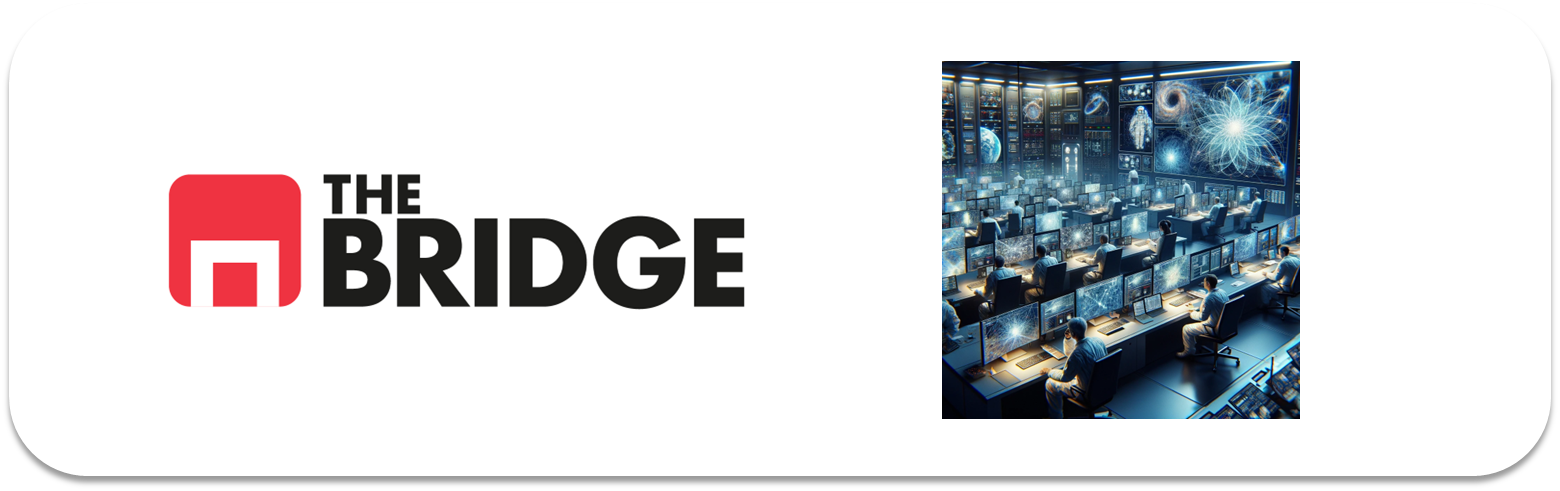

## PRACTICA OBLIGATORIA: **Redes Convolucionales**

* La práctica obligatoria de esta unidad consiste en un ejercicio de construcción de una red convolucional con Keras para la clasificación de imagenes de simpáticos perretes y gatetes. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [408]:
import bootcampviztools as bt
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd 
import random

from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from skimage.io import imread
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from time import time



In [ ]:
Convolucional: Operación matemática convolución 
1. Capmo recpetivo- Kernel
2. Extractor de Features -> Aplanado + Modelo



### Problema de Negocio y dataset

Una conocida empresa de información inmobiliaria utiliza un CAPTCHA visual de perros y gatos para detectar webscrappings intensivos y ataques de denegación de servicio. Últimamente, ha detectado que su sistema está empezando a flojear, es decir que hay muchos sistemas de detección automática de imágenes que son capaces de detectar que es un perro y un gato y salterse el CAPTCHA antirobots. Por eso nos ha pedido que entrenemos un modelo potente de clasificación que emule a estos sistemas con el objetivo de emplear como fotografías para el CAPTCHA aquellas que no sepa detectar este sistema emulador de chicos malos.  

Pues manos a la obra, tenemos que seleccionar en un conjunto de 1000 imágenes aquellas que peor se le daría a un potencial sistema anti-CAPTCHA.  

Para ello vamos a emplear un conjunto de train de 4000 imágenes de perretes y gatetes que se encuentran distribuidas en "data" en cuatro directorios "github_train_0",  "github_train_1", "githun_train_2" y "github_train_3". Los datos de las imagenes que tenemos que clasificar y luego seleccionar como las más "difíciles" están en "data" en el directorio "github_test".


### Se pide

1. Crear los datasets X,y de train y test, leyendo las imágenes de los directorios correspondientes (tendrás que leer todas las imágenes de los cuatro directorios para train) y a la vez que se leen adpatar su resolución para que todas tengan un tamaño de 32x32. En este caso puedes adaptar las funciones de los ejercicios de la unidad. NOTA: Ten en cuenta que la clase a la que pertenece en la foto está en el nombre del archivo.

2. Crea un modelo DL basado en redes convolucionales con al menos dos juegos Convolucional-Pooling. Sigue todo el proceso de ML (visualización del dataset, MiniEDA, Construcción del modelo)

3. Entrenar el modelo con un callback de Earlystopping con paciencia la que tengas :-). Muestra su historial de entrenamiento.

4. Evalua el modelo, haz un reporte de clasificacion y muestra la matriz de confianza.

5. Es el momento de seleccionar las imagenes: Selecciona el 10% de imágenes mal clasificadas de una y otra clase que tengan el mayor nivel de confianza de que pertenencían a la clase errónea. Es decir las imágenes de perros clasificadas como gatos y con la probabilidad de ser perror más alta.


### Extra (para hacer en clase)

Repite los pasos 3 a 5 utilizando el generador de imágenes sintéticas o Image Augmentation de Keras. 



### Resolución

### #1

#### Carga de Datos (y train test split de regalo)

*Vamos a crear los datasets, adaptamos la función para que en vez de admitir un único directorio admita una lista de ellos*

In [409]:
def read_data(directorios, reshape_dim = (32,32)):
    X = [] 
    y = []
    mapa_imagen_fichero = []
    directorios = directorios if isinstance(directorios, list) else [directorios] if isinstance(directorios,str) else []
    for directorio in directorios:
        for file in os.listdir(directorio):
            image = imread('/'.join([directorio, file]))
            image = cv2.resize(image, reshape_dim) # Redimensionamos las imágenes a 32x32
            X.append(image)
            y.append(file.split(".")[0]) # El nombre es la clase
            mapa_imagen_fichero.append(file) # Esto para ver la imagen al completo con su resolución

    return np.array(X),np.array(y),mapa_imagen_fichero

*Empezamos con el X_train, y_train a partir de los subdirectorios correspondientes*

In [410]:
PATH_DATA = "./data/"
directorios  = [f"{PATH_DATA}github_train_{i}" for i in range(0,4)]
X_train,y_train, train_map = read_data(directorios)

*Ahora el test*

In [411]:
directorios  = [PATH_DATA + "github_test"]
X_test,y_test, test_map = read_data(directorios)

#### Visualización de datos

*Un pequeño vistazo al tipo y tamaño de nuestros datos*

In [412]:
X_train.shape

(4000, 32, 32, 3)

*Train: 4000 imágenes, de 32x32 y en color, 3 canales*

In [413]:
type(X_train[123])

numpy.ndarray

*Y son arrays como ya sabíamos porque es lo que retorna nuestra función :-)*

In [414]:
X_test.shape

(1000, 32, 32, 3)

*Test: 1000 imágenes de 32x32, en color, 3 canales*

*Para ver nuestros datos, reutilizamos directamente la función creada para el ejercicio de los paisajes*

In [415]:
def show_images_batch(pets, names = [], n_cols = 5, size_scale = 2):
    n_rows = ((len(pets) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1*size_scale))
    for index, pet in enumerate(pets):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(pet, cmap = "Greys")
        plt.axis("off")
        if len(names):
            plt.title(names[index])

In [416]:
def show_images_files(pets, names = [], n_cols = 5, size_scale = 2, train = True, indice = 0):
    n_rows = ((len(pets) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1*size_scale))
    for index, filepet in enumerate(pets):
        plt.subplot(n_rows, n_cols, index + 1)
        if train:
            pet = imread(PATH_DATA + f"github_train_{indice}/" + filepet)
        else:
            pet = imread(PATH_DATA + "github_test/" + filepet)
        plt.imshow(pet, cmap = "Greys")
        plt.axis("off")
        if len(names):
            plt.title(names[index])

*Veamos algunas seleccionadas aleatoriamente*

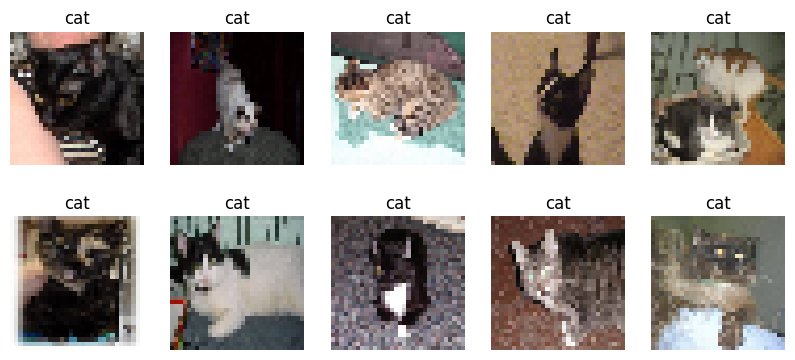

In [417]:
indices = np.random.randint(100,300,10)
show_images_batch(X_train[indices], names= y_train[indices])

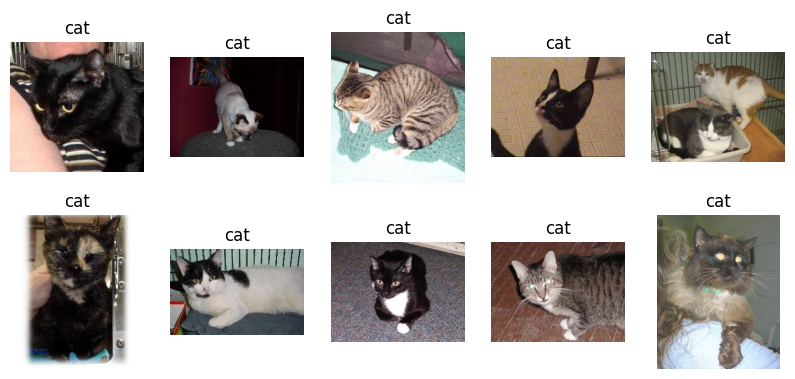

In [418]:
show_images_files([train_map[i] for i in indices], names= y_train[indices])

*Nos salen solo gatos porque están ordenados, veamos algunos simpáticos perritos*

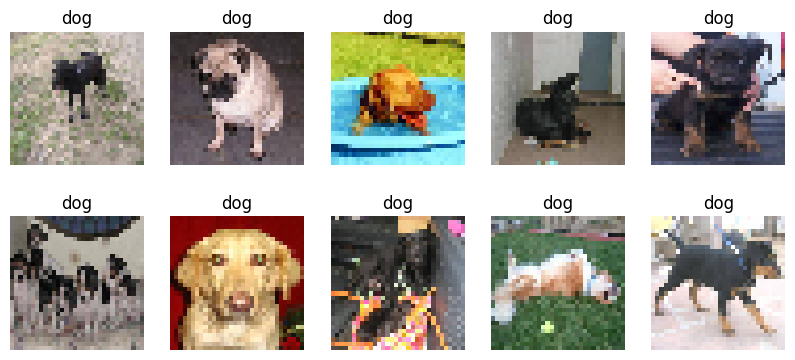

In [419]:
indices = np.random.randint(2000,2300,10)
show_images_batch(X_train[indices], names= y_train[indices])

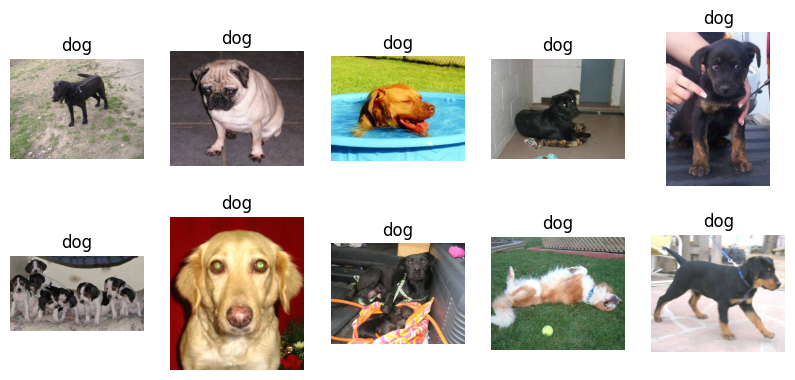

In [420]:
show_images_files([train_map[i] for i in indices], names= y_train[indices], train=2, indice=2)

#### MiniEDA

*Como en todo modelo de ML, y DL es un subconjunto, vamos a analizar el target*

In [421]:
pd.Series(y_train).value_counts(True)

cat    0.5
dog    0.5
Name: proportion, dtype: float64

*Tenemos un dataset completamente equilibrado para un problema de clasificación binaria*

In [423]:
X_train.shape

(4000, 32, 32, 3)

#### Escalado

*Siempre es interesante hacer un escalado aunque sea el caso de imágenes con los canales ya "escalados" entre 0 y 255. Reducir el rango de 0/255 a -1/1 o 0/1, aprovecha mejoras las funciones de activación y evita problemas de saturación.*

In [422]:
X_train = X_train/255
X_test = X_test/255

#### Shuffle [Optativo]

*Como los datos están ordenados, es necesario darle cierta aleatoriedad, aunque internamente se van a procesar aleatoriamente al construir los batches, si de partida estan ordenados*

*EXTRA: Construimos un randomforest como baseline*

In [424]:
def aplana_escala_gris(array_in, grises = True):
    def convertir_a_escala_de_grises(imagen_color):
        coeficientes = np.array([0.2989, 0.5870, 0.1140])
        imagen_gris = np.dot(imagen_color[...,:3], coeficientes)
        return imagen_gris

    if array_in.shape[-1] == 3 and grises:
        array_in = np.array([convertir_a_escala_de_grises(imagen) for imagen in array_in])
    return array_in.reshape(array_in.shape[0],-1)

In [425]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

X_train_rf = aplana_escala_gris(X_train)
len(X_train_rf[0])


1024

In [429]:
from sklearn.utils import shuffle
X_train_rf_shuffled, y_train_shuffled = shuffle(X_train_rf, y_train, random_state = 42)

In [430]:
y_train[0:10]

array(['cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat',
       'cat'], dtype='<U3')

In [431]:
y_train_shuffled[0:10]

array(['cat', 'dog', 'cat', 'dog', 'dog', 'cat', 'cat', 'cat', 'cat',
       'cat'], dtype='<U3')

In [432]:
rf_clf = RandomForestClassifier()
np.mean(cross_val_score(rf_clf,X_train_rf_shuffled, y_train_shuffled, cv = 5, scoring = "accuracy"))

0.61

*Un 61% de accuracy es lo mínimo que debemos exigir*

In [23]:
def read_data(path, im_size):
    X = []
    Y = []

    for file in os.listdir(path):
        image = imread(path + '/' + file)
        smallimage = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))
        
        X.append(smallimage)
        
        category = file.split('.')[0]
        if category == 'dog':
            Y.append(1)
        else:
            Y.append(0)

    return np.array(X), np.array(Y)
    

X_train, y_train = read_data(TRAIN_PATH, IMAGE_SIZE)
X_test, y_test = read_data(TEST_PATH, IMAGE_SIZE)

print(X_train.shape)
print(X_test.shape)

(6576, 32, 32, 3)
(3456, 32, 32, 3)


(32, 32, 3)


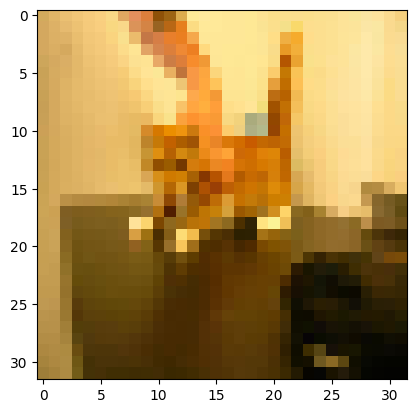

In [24]:
print(X_train[0].shape)
plt.imshow(X_train[0]);

In [ ]:
X_train[0]

array([[[210, 171,  93],
        [224, 181, 103],
        [235, 192, 114],
        ...,
        [253, 227, 157],
        [250, 218, 143],
        [245, 208, 127]],

       [[212, 168,  95],
        [221, 177, 102],
        [230, 186, 111],
        ...,
        [250, 231, 162],
        [250, 218, 143],
        [244, 215, 137]],

       [[212, 168,  95],
        [220, 176, 101],
        [222, 178, 103],
        ...,
        [249, 230, 161],
        [251, 219, 144],
        [249, 219, 147]],

       ...,

       [[173, 136,  65],
        [176, 139,  68],
        [173, 139,  65],
        ...,
        [ 10,  10,   2],
        [ 11,  10,   5],
        [  9,   8,   3]],

       [[166, 132,  61],
        [173, 136,  65],
        [174, 140,  68],
        ...,
        [  5,   6,   1],
        [  4,   5,   0],
        [  4,   5,   0]],

       [[158, 126,  57],
        [166, 131,  60],
        [173, 139,  67],
        ...,
        [  4,   4,   1],
        [  3,   3,   1],
        [  3,   3,   1]]

#### EXTRA-Tool: Save data
Podemos guardar los arrays de numpy en un archivo `.npz`, de tal manera que luego sea más rápido importarlo

In [133]:
np.savez(PATH_DATA + 'data.npz', X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

Para cargar

In [134]:
data = np.load(PATH_DATA + 'data.npz')

X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

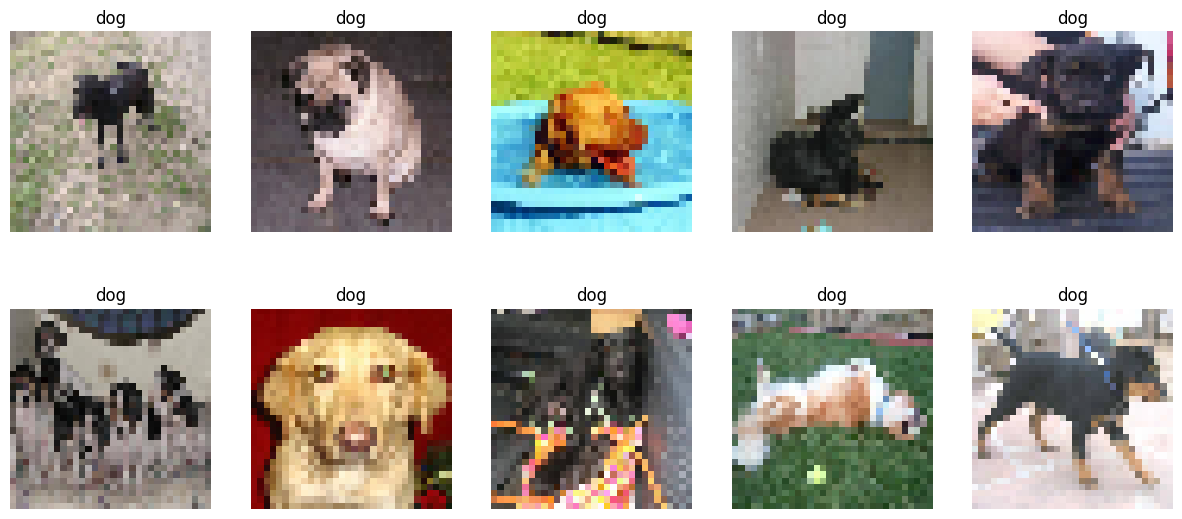

In [433]:
show_images_batch(X_train[indices],y_train[indices],size_scale=3)

### #2

*A la hora de crear un modelo DL, recuerda que necesitamos fijar una serie de hiperparámetros de partida, no es como cuando instanciamos nuestros modelos en Sklearn que ya vienen "preconfigurados". El orden en este caso suele ser:*

*1. Topología (I): Capas, conexión entre capas, vamos a hacer expansión-reducción de features, reducción-expansión, prismas, aplanamiento, dropout, etc*  
*2. Topología (II): Hiperparámetros por capa: unidades para las densas, kernel, strides, filtros, padding para convolucionales y pooling, drop-out rate para drop-out, etc*  
*3. Otros hiperparámetros: Tipo de optimizador (y sus hiperparámetros, en general usaremos los por defecto, salvo en ocasiones el learning rate), tamaño del batch (aunque en general será 32 y dependerá del tamaño del dataset de train), épocas de entrenamiento, % del conjunto de validación.*  
*4. Métrica y función de pérdida*  
*5. Uso de callbacks (en Keras): En general usaremos o EarlyStopping y/o ModelCheckpoint, pero [aquí](https://keras.io/api/callbacks/) tienes unas cuantas más de las estándar de Keras*  

*Vamos a crear una topología parecida a la de la figura*

#### Topología I-II:

*Vamos a construir una red como la de la figura:*



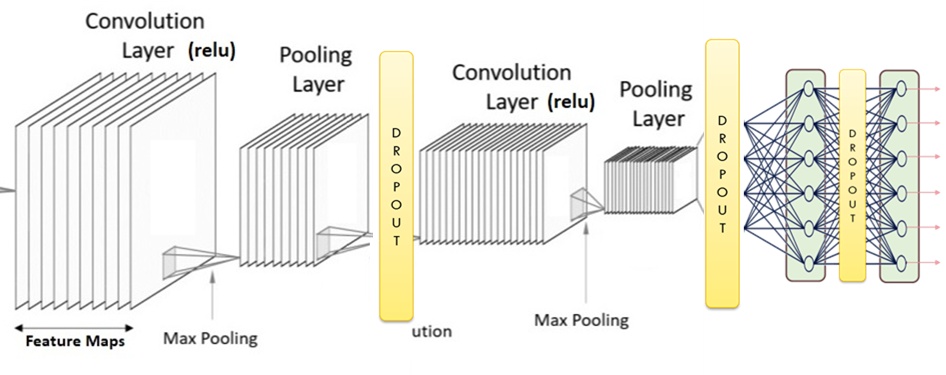

* **Conv Layer**: extraerá diferentes features de las imagenes
* **Pooling Layer**: Reduce las dimensiones de las imágenes tras una capa convolucional
* **Fully Connected Layer**: Tras las capas convolucionales, aplanamos las features y las introducimos como entrada de una red neuronal normal.
* **Output Layer**: Las predicciones de la red

*Con los siguientes hiperparámetros:*  

***Primer juego Conv-Pooling:*** 
* *Conv -> kernel de 3x3, stride = (1,1), padding = "same", activation = "relu", numero de filtros = 64*  
* *Pooling -> max, kernel 2x2, stride = (2,2)) -> Vamos a reducir en 2x2, 4 el número de features*  
* *Features de salida: 16*16*64 = 16384

*Capa Dropout: 0.25 de ratio*

***Segundo juego con Conv-Pooling:*** *Aplicamos expansión, aumentando el número de filtros, pensamos en buscar más características de características*  
* *Conv -> kernel de 3x3, stride = (1,1), padding = "same", activation = "relu", numero de filtros = 128*  
* *Pooling -> max, kernel 2x2, stride = (2,2)) -> Vamos a reducir en 2x2, 4 el número de features*  
* Features de salida 8*8*128 = 8192
  
*Capa Dropout: 0.25 de ratio*  

*Capa aplanadora: Flatten() -> Nos deja cada instancia en un vector de 8192 features  
***Cabeza clasificacion:*** *1 densa oculta y la de salida. La oculta empezamos con una reducción de 8192 a 512, un factor de 16. Podríamos haberla dejado en 32x32 = 1024 features que es el número que meteríamos en un modelo tradicional*
* *Capa Oculta Densa: 128 unidades, activación "relu"*
* *Capa densa de salida: 1 unidad (es clasificador binario), activacuón "softmax"*


In [434]:
layers = [
    keras.layers.Conv2D(64,(3,3), activation = 'relu', padding= "same",input_shape=(32,32,3)), # Padding "Valid" (sin padding), "Same" (ajusta para que entre todo), Integer -> el relleno que yo quiera. 
    keras.layers.MaxPooling2D(pool_size = (2,2), padding = "same"), # 2x2 -> A dividir por 2 la resolución de cada dimensión de la capa anterior, 32x32 -> 16x16 
    keras.layers.Dropout(rate = 0.25),
    
    keras.layers.Conv2D(128,(3,3), activation = 'relu', padding= "same"),
    keras.layers.MaxPooling2D(pool_size = (2,2), padding = "same"), # 16x16 -> 8x8
    keras.layers.Dropout(rate = 0.25),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'), # 1024 -> 32*32
    keras.layers.Dropout(rate = 0.5),
    #keras.layers.Dense(2, activation='softmax') # -> loss = "sparse_categorical_crossentropy" (categorical_crossentropy es cuando y_train = [0,1] o y_train = [0,0,1,0,0]
    keras.layers.Dense(1, activation='sigmoid') # -> loss = "binary_crossentropy"
]
model = keras.Sequential(layers)

#### Otros hiperparámetros

*Veamos el tamaño de entrada de datos:*

In [435]:
X_train.size

12288000

*Nos vale un Adam, podríamos probar un SGD*

In [436]:
optimizer = keras.optimizers.Adam()

In [437]:
metrics = ["accuracy"] # dataset equilibrado
loss = "binary_crossentropy" # Es un clasificador binario

*Tenemos 4000 instancias, no son tantas así que emplearemos un batch size de 32*

In [441]:
batch_size = 32 
len(X_train)/batch_size

125.0

*Cada época tendrá 125 pasadas por el algoritmo de entrenamiento, también llamados steps. Incluso podríamos aumentar a 48-64 el batch_size*

*Escogemos un número alto de épocas y usamos un EarlyStopping con paciencia 10 para no tener que depender del número de épocas*

In [442]:
num_epochs = 100

In [443]:
earlyS = keras.callbacks.EarlyStopping(patience = 10)

*Compilamos y mostramos un resumen del modelo*

In [444]:
model.compile(optimizer= optimizer,
              loss= loss,
              metrics= metrics)

In [445]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 16, 16, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_45 (Dropout)        (None, 16, 16, 64)        0         
                                                                 
 conv2d_37 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_37 (MaxPooli  (None, 8, 8, 128)         0         
 ng2D)                                                           
                                                                 
 dropout_46 (Dropout)        (None, 8, 8, 128)       

### #3

*Hora de entrenar y mostrar ese entrenamiento, pero primero vamos a lanzar una sóla época para ver tiempos y antes convertir el target a numérico*

In [449]:
y_train[np.array([1,2,3560])]

array(['cat', 'cat', 'dog'], dtype='<U3')

In [450]:
y_train_num = np.array([0 if y == "cat" else 1 for y in y_train]) # Tiene que ser un array de numpy o no lo admitirá el fit si queremos validation set

*Como vamos a tener que lanzar varios entrenamientos para poder simular un reseteo de pesos creamos una función que nos hace eso, nos devuelve el modelo preparado para un nuevo fit*

In [451]:
def prepare_model(resolucion = (32,32)):
    layers = [
    keras.layers.Conv2D(64,(3,3), activation = 'relu', padding= "same",input_shape=(32,32,3)),
    keras.layers.MaxPooling2D(pool_size = (2,2), padding = "same"),
    keras.layers.Dropout(rate = 0.25),
    
    keras.layers.Conv2D(128,(3,3), activation = 'relu', padding= "same"),
    keras.layers.MaxPooling2D(pool_size = (2,2), padding = "same"),
    keras.layers.Dropout(rate = 0.25),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(rate = 0.5),
    keras.layers.Dense(1, activation='sigmoid')
    ]
    model = keras.Sequential(layers)
    optimizer = keras.optimizers.Adam()
    metrics = ["accuracy"] # dataset equilibrado
    loss = "binary_crossentropy" # Es un clasificador binario
    model.compile(optimizer= optimizer,
              loss= loss,
              metrics= metrics)
    return model
    

In [452]:
model = prepare_model()
t_zero = time()
history = model.fit(X_train,
          y_train_num,
          epochs=1,
          batch_size= batch_size,
          callbacks = [earlyS],
          validation_split=0.2)
dur_epoca = time()-t_zero

100/100 [==============================] - 10s 88ms/step - loss: 0.6905 - accuracy: 0.6106 - val_loss: 0.7879 - val_accuracy: 0.0000e+00


In [453]:
print(dur_epoca)

10.137544631958008


*5-6 segundos podemos usar un número alto de épocas, pero eso sí ojo con los resultados por si son excesivamente positivos, tendríamos que estar preocupados*

In [454]:
model = prepare_model()
t_zero = time()
history = model.fit(X_train,
          y_train_num,
          epochs= num_epochs,
          batch_size= batch_size,
          callbacks = [earlyS],
          validation_split=0.2)
dur_epoca = time()-t_zero

Epoch 1/100
100/100 [==============================] - 10s 87ms/step - loss: 0.6883 - accuracy: 0.6134 - val_loss: 0.7767 - val_accuracy: 0.0000e+00
Epoch 2/100
100/100 [==============================] - 9s 87ms/step - loss: 0.6512 - accuracy: 0.6253 - val_loss: 0.8771 - val_accuracy: 0.0012
Epoch 3/100
100/100 [==============================] - 9s 86ms/step - loss: 0.6159 - accuracy: 0.6666 - val_loss: 0.8979 - val_accuracy: 0.2600
Epoch 4/100
100/100 [==============================] - 9s 87ms/step - loss: 0.5829 - accuracy: 0.6859 - val_loss: 0.6665 - val_accuracy: 0.6338
Epoch 5/100
100/100 [==============================] - 9s 87ms/step - loss: 0.5523 - accuracy: 0.7206 - val_loss: 0.6632 - val_accuracy: 0.6075
Epoch 6/100
100/100 [==============================] - 9s 86ms/step - loss: 0.5377 - accuracy: 0.7253 - val_loss: 0.6433 - val_accuracy: 0.6700
Epoch 7/100
100/100 [==============================] - 9s 86ms/step - loss: 0.5154 - accuracy: 0.7431 - val_loss: 0.8233 - val_accu

In [455]:
y_test_num = np.array([0 if y == "cat" else 1 for y in y_test])
model.evaluate(X_test,y_test_num)

32/32 [==============================] - 1s 17ms/step - loss: 0.6454 - accuracy: 0.7650


[0.6454057693481445, 0.7649999856948853]

*Estos resultados pueden estar afectados por el orden de los datos de entrada recuerda que estaban completamente ordenados, primero gatos y perros. Vamos a shufflearlos*

In [ ]:
#from sklearn.utils import shuffle

In [456]:
X_s,y_s = shuffle(X_train,y_train_num)

In [457]:
model = prepare_model()
t_zero = time()
history_shuffle = model.fit(X_s,
          y_s,
          epochs= num_epochs,
          batch_size= batch_size,
          callbacks = [earlyS],
          validation_split=0.2)
dur_epoca = time()-t_zero

Epoch 1/100
100/100 [==============================] - 10s 88ms/step - loss: 0.6993 - accuracy: 0.5259 - val_loss: 0.6808 - val_accuracy: 0.5625
Epoch 2/100
100/100 [==============================] - 9s 89ms/step - loss: 0.6607 - accuracy: 0.6122 - val_loss: 0.6254 - val_accuracy: 0.6413
Epoch 3/100
100/100 [==============================] - 9s 86ms/step - loss: 0.6156 - accuracy: 0.6653 - val_loss: 0.6290 - val_accuracy: 0.6475
Epoch 4/100
100/100 [==============================] - 9s 90ms/step - loss: 0.5794 - accuracy: 0.6931 - val_loss: 0.5875 - val_accuracy: 0.6775
Epoch 5/100
100/100 [==============================] - 9s 87ms/step - loss: 0.5495 - accuracy: 0.7166 - val_loss: 0.6067 - val_accuracy: 0.6425
Epoch 6/100
100/100 [==============================] - 9s 88ms/step - loss: 0.5411 - accuracy: 0.7250 - val_loss: 0.5848 - val_accuracy: 0.6687
Epoch 7/100
100/100 [==============================] - 8s 84ms/step - loss: 0.5076 - accuracy: 0.7497 - val_loss: 0.5680 - val_accuracy

In [458]:
y_test_num = np.array([0 if y == "cat" else 1 for y in y_test])
model.evaluate(X_test,y_test_num)

32/32 [==============================] - 1s 17ms/step - loss: 0.7375 - accuracy: 0.7400


[0.7375446557998657, 0.7400000095367432]

*Pintemos la evolución de los dos entrenamientos*

In [459]:
df_evol = pd.DataFrame(history.history)
df_evol_shuffle = pd.DataFrame(history_shuffle.history)

<Axes: >

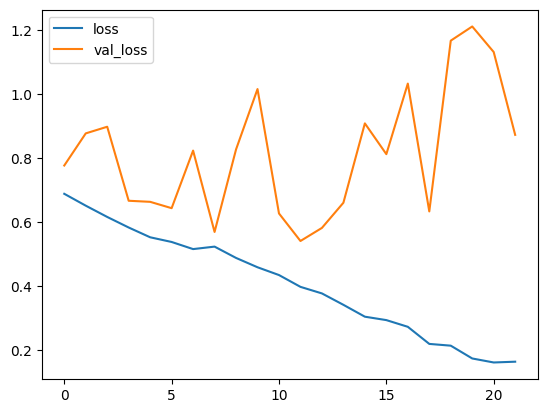

In [460]:
df_evol[["loss","val_loss"]].plot()

<Axes: >

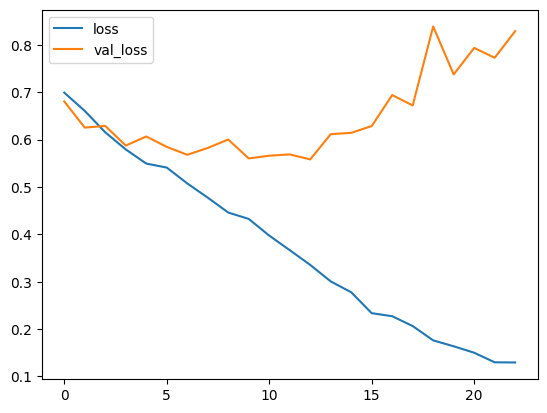

In [461]:
df_evol_shuffle[["loss","val_loss"]].plot()

*No siempre debemos parar en cuanto val y train se separan pero tampoco esperar mucho más. El no aleatorizar de primeras hace que el entrenamiento sin shuffling sea más oscilante, pero en este caso el impacto ha sido menor (hay un shuffle activado en el fit de los modelos keras)*

### #4

In [462]:
predictions = model.predict(X_test)

32/32 [==============================] - 1s 15ms/step


In [465]:
y_pred = ["dog" if prediction[0] > 0.5 else "cat" for prediction in model.predict(X_test)]
print(classification_report(y_test, y_pred))

32/32 [==============================] - 1s 19ms/step
              precision    recall  f1-score   support

         cat       0.76      0.70      0.73       500
         dog       0.72      0.78      0.75       500

    accuracy                           0.74      1000
   macro avg       0.74      0.74      0.74      1000
weighted avg       0.74      0.74      0.74      1000



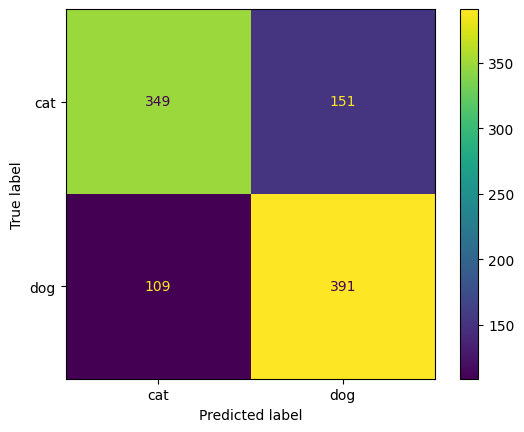

In [466]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

*Capta más gatos pero al precio de ser menos preciso a la hora de escoger gatos, dice que son más gatos de los que son, es más preciso con los perros y por eso los capta en menor número*

### #5

*Aprovechemos que el test está también ordenado:*

In [ ]:
Si es menor 0.5
Yo pensaré que es un gato, y pensaré con mayor intensidad o confianza cuanto menor sea la probabilidad -> 1 - probabilidad
Si es mayor que 0.5
Pensaré que es un perro, y pensaré con mayor intensidad o confianza cuanto mayor sea la probabilidad -> probabilidad

In [467]:
confidencia = [ (1-prediction[0]) if prediction[0] <= 0.5 else prediction[0] for prediction in model.predict(X_test)]
df_pred = pd.DataFrame({"ficheros": test_map,"True": [file.split(".")[0] for file in test_map],"Prediction": y_pred, "Confidencia": confidencia})
df_pred

32/32 [==============================] - 1s 16ms/step


,ficheros,True,Prediction,Confidencia
0,cat.10705.jpg,cat,dog,0.923362
1,cat.10711.jpg,cat,cat,0.538323
2,cat.10714.jpg,cat,cat,0.970978
3,cat.10715.jpg,cat,dog,0.934158
4,cat.10716.jpg,cat,dog,0.994354
...,...,...,...,...
995,dog.9883.jpg,dog,dog,0.651462
996,dog.9884.jpg,dog,dog,0.942131
997,dog.9885.jpg,dog,dog,0.762010
998,dog.9889.jpg,dog,dog,0.902549


In [468]:
errores = df_pred["True"] != df_pred["Prediction"]
son_gatos = df_pred["True"] == "cat"
son_perros = df_pred["True"] == "dog"
gatos_dificiles = df_pred[son_gatos & errores]["Confidencia"].nlargest(int(len(df_pred[son_gatos & errores])*0.1)).index.to_list()
perros_dificiles = df_pred[son_perros & errores]["Confidencia"].nlargest(int(len(df_pred[son_perros & errores])*0.1)).index.to_list()


In [469]:
df_pred.loc[gatos_dificiles]

,ficheros,True,Prediction,Confidencia
337,cat.11793.jpg,cat,dog,1.000000
359,cat.11867.jpg,cat,dog,0.999994
107,cat.11018.jpg,cat,dog,0.999934
213,cat.11398.jpg,cat,dog,0.999896
229,cat.11462.jpg,cat,dog,0.999889
490,cat.12323.jpg,cat,dog,0.999811
377,cat.11929.jpg,cat,dog,0.999053
491,cat.12325.jpg,cat,dog,0.998678
289,cat.11642.jpg,cat,dog,0.998379
284,cat.11636.jpg,cat,dog,0.997966


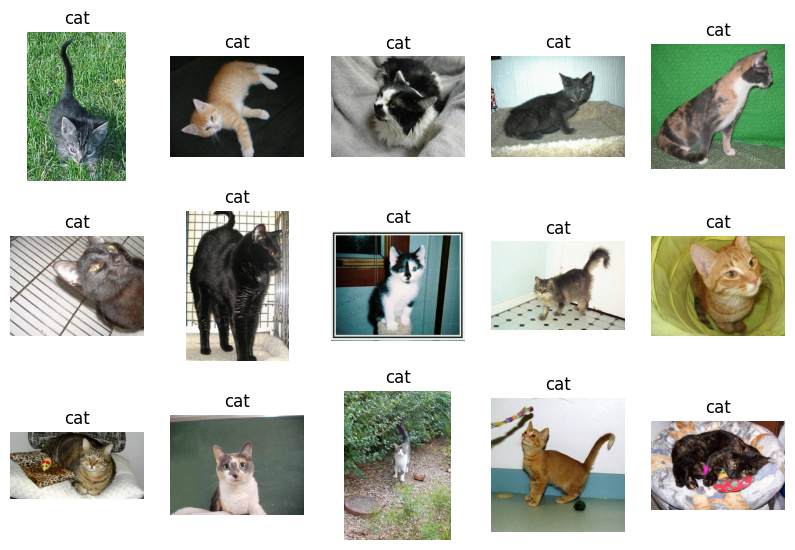

In [470]:
show_images_files(df_pred.loc[gatos_dificiles]["ficheros"], df_pred.loc[gatos_dificiles]["True"].values, train = False)

In [472]:
df_pred.loc[perros_dificiles]

,ficheros,True,Prediction,Confidencia
886,dog.9499.jpg,dog,cat,0.999459
680,dog.8764.jpg,dog,cat,0.999422
871,dog.9449.jpg,dog,cat,0.999045
930,dog.9639.jpg,dog,cat,0.998283
915,dog.9606.jpg,dog,cat,0.995586
808,dog.9177.jpg,dog,cat,0.995254
888,dog.9509.jpg,dog,cat,0.995186
537,dog.8215.jpg,dog,cat,0.994322
603,dog.8485.jpg,dog,cat,0.994237
611,dog.8500.jpg,dog,cat,0.994009


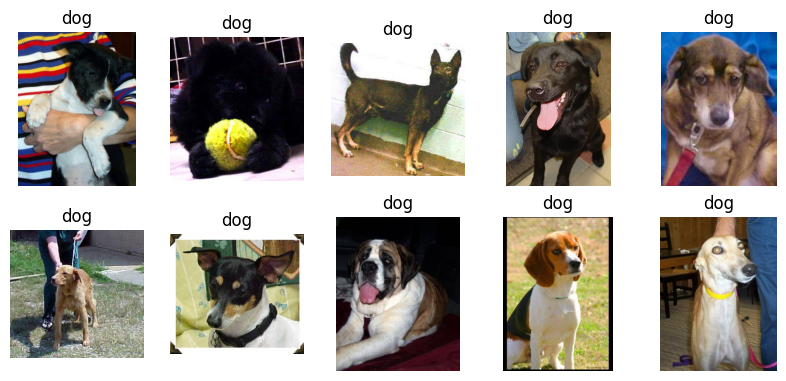

In [471]:
show_images_files(df_pred.loc[perros_dificiles]["ficheros"], df_pred.loc[perros_dificiles]["True"].values, train = False)

*La discusión es si la resolución afecta, que sí y tendríamos que hacerlo suponiendo esa resolución. Por otro lado, el que sean imágenes que a un humano no le costarían pero sí a un modelo las hace más idóneas para el trabajo porque fallarlas es signo inequívoco de que es un modelo*

### EXTRA

*Para terminar vamos a ver una de las técnicas que se pueden emplear para tener más informacio´n en un clasificador de imágenes (y que podría servir hasta cierto punto como técnica de generación sintética o oversampling para equilibrar datasets)*

*Vamos a ver cómo usar los augmentadores de datasets de keras para imágenes*

#### Image data generator

*Primero vamos a coger el train y vamos a construir un dataset con la estructura filename-category que nos servirá después para ver otra capacidad de keras*

In [473]:
directorios  = [f"{PATH_DATA}github_train_{i}" for i in range(0,4)]
ficheros = []
clases = []
for directorio in directorios:
    ficheros += [directorio + "/" + fichero for fichero in os.listdir(directorio)]
    clases += [fichero.split(".")[0] for fichero in os.listdir(directorio)]
train_augmented = pd.DataFrame({"filename": ficheros,"category": clases})
train_augmented.head(10)

    

,filename,category
0,./data/github_train_0/cat.1000.jpg,cat
1,./data/github_train_0/cat.10010.jpg,cat
2,./data/github_train_0/cat.10012.jpg,cat
3,./data/github_train_0/cat.10013.jpg,cat
4,./data/github_train_0/cat.10017.jpg,cat
5,./data/github_train_0/cat.1002.jpg,cat
6,./data/github_train_0/cat.10023.jpg,cat
7,./data/github_train_0/cat.10024.jpg,cat
8,./data/github_train_0/cat.10027.jpg,cat
9,./data/github_train_0/cat.10030.jpg,cat


*El objeto ImageDataGenerator va a servirnos para generar una imagen modificada de una imagen original, mediante rotacinoes, reescalados, desplazamientos, zooms, flips, etc*

In [474]:
'''
NO genera X imagenes sinteticas. Simplemente en cada epoch, en vez de coger el
dataset tal cual lo tiene, coge una de esas imágenes sintéticas, algo diferentes,
Asi eumentan sus perspectivas
Las imagenes las va generando segun entrena
https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/

'''

example_df = train_augmented.sample(n=1).reset_index(drop=True)

train_datagen = ImageDataGenerator(
    rotation_range=15, # Angulo de rotación
    rescale=1./255, # Escalado, ya nos escala las imágenes
    shear_range=0.1, # Inclina las imágenes, no es giro es inclinación como hacerlas "cursivas"
    zoom_range=0.2, # Zoom
    horizontal_flip=True, # giro horizontal o especular
    width_shift_range=0.1, # Desplazamiento horizontal de los pixeles
    height_shift_range=0.1 # Desplazamiento vertical de los píxeles
)


*Dos formas de utilizarlo, desde la lectura de ficheros y desde los datos*

In [475]:
example_df

,filename,category
0,./data/github_train_1/cat.2262.jpg,cat


In [476]:

example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    x_col='filename',
    y_col='category',
    target_size=(32, 32),
)

Found 1 validated image filenames belonging to 1 classes.


*Generamos ahora 15 imágenes sintéticas, se le aplican los cambios aletoriamente*

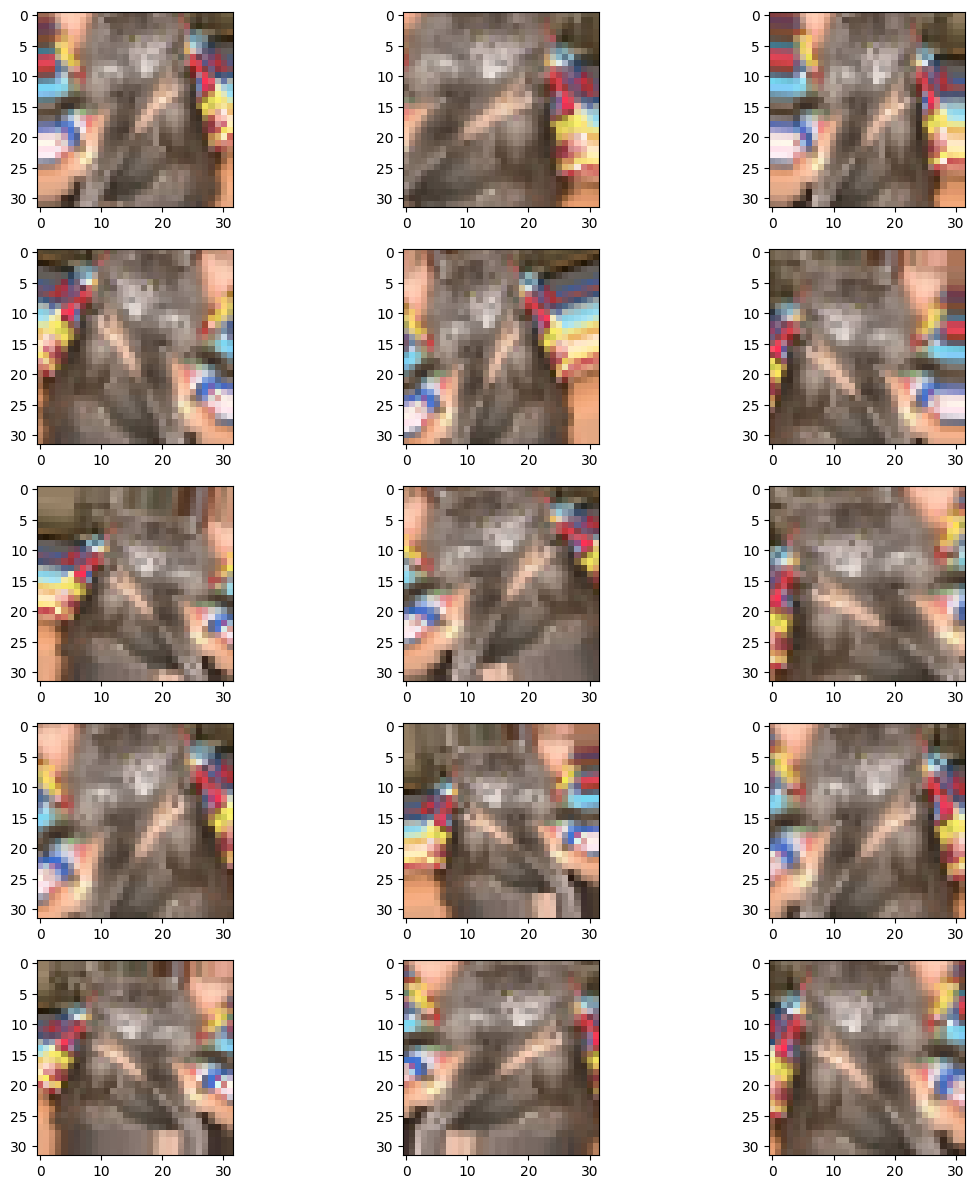

In [477]:
plt.figure(figsize=(12, 12))

for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [478]:

example_generator = train_datagen.flow(
    X_train[0:3]*255,
    y_train[0:3]
)

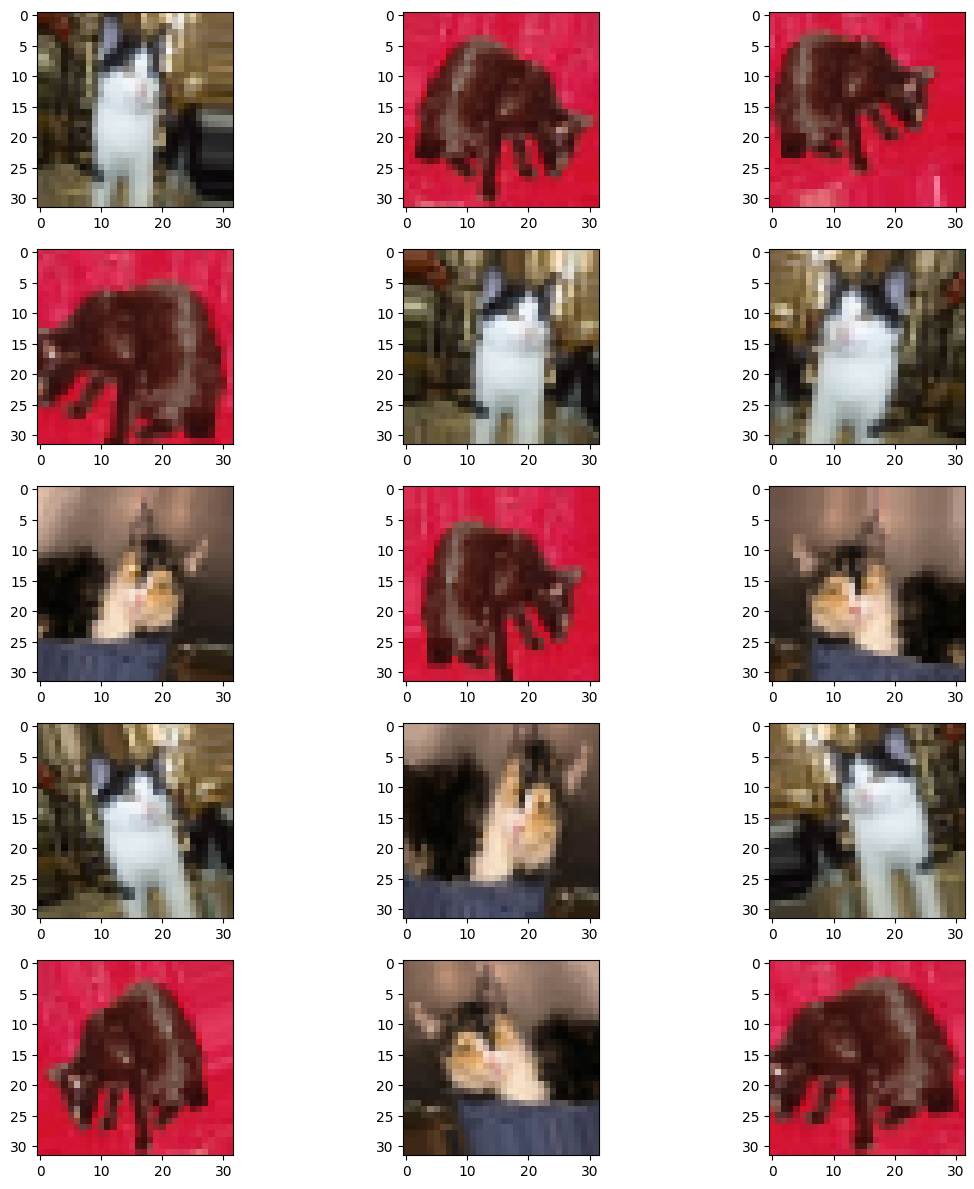

In [479]:
plt.figure(figsize=(12, 12))

for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

#### Aplicado a un modelo y un entrenamiento

*Tenemos que generar el dataset de validación aparte, porque ese no va a llevar aumentación*

In [480]:
train_df, validate_df = train_test_split(train_augmented,
                                         test_size=0.20,
                                         random_state=42)

In [481]:
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [482]:
train_df

,filename,category
0,./data/github_train_3/dog.9982.jpg,dog
1,./data/github_train_0/cat.2440.jpg,cat
2,./data/github_train_2/dog.9981.jpg,dog
3,./data/github_train_1/cat.1657.jpg,cat
4,./data/github_train_0/cat.2753.jpg,cat
...,...,...
3195,./data/github_train_1/cat.1303.jpg,cat
3196,./data/github_train_1/cat.1882.jpg,cat
3197,./data/github_train_0/cat.487.jpg,cat
3198,./data/github_train_3/dog.11270.jpg,dog


In [483]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

print("Shape train", total_train)
print("Shape validation", total_validate)
validate_df.head()

Shape train 3200
Shape validation 800


,filename,category
0,./data/github_train_0/cat.2936.jpg,cat
1,./data/github_train_3/dog.11231.jpg,dog
2,./data/github_train_0/cat.2820.jpg,cat
3,./data/github_train_3/dog.12368.jpg,dog
4,./data/github_train_2/dog.9978.jpg,dog


# Training Generator

In [484]:
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    x_col='filename',
    y_col='category',
    target_size=(32, 32),
    class_mode='binary', # Porque es binaria, si fuera multiclase y en un sólo valor -> "sparse" (otras configuraciones, ver la documentación)
    batch_size= batch_size
)

Found 3200 validated image filenames belonging to 2 classes.


### Validation Generator

In [485]:
validation_datagen = ImageDataGenerator(rescale=1./255) # Solo vamos a reescalar
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    x_col='filename',
    y_col='category',
    target_size=(32, 32),
    class_mode='binary',
    batch_size= batch_size
)

Found 800 validated image filenames belonging to 2 classes.


# Fit Model

In [486]:
model = keras.Sequential(layers)

model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [487]:
history = model.fit(
    train_generator, 
    epochs= num_epochs,
    validation_data=validation_generator,
    callbacks= earlyS
)

Epoch 1/100
100/100 [==============================] - 15s 136ms/step - loss: 0.7107 - accuracy: 0.5278 - val_loss: 0.6921 - val_accuracy: 0.4712
Epoch 2/100
100/100 [==============================] - 13s 133ms/step - loss: 0.6909 - accuracy: 0.5200 - val_loss: 0.6883 - val_accuracy: 0.4988
Epoch 3/100
100/100 [==============================] - 14s 137ms/step - loss: 0.6826 - accuracy: 0.5634 - val_loss: 0.6611 - val_accuracy: 0.6175
Epoch 4/100
100/100 [==============================] - 14s 143ms/step - loss: 0.6695 - accuracy: 0.5906 - val_loss: 0.6552 - val_accuracy: 0.6075
Epoch 5/100
100/100 [==============================] - 14s 140ms/step - loss: 0.6637 - accuracy: 0.5984 - val_loss: 0.6421 - val_accuracy: 0.6075
Epoch 6/100
100/100 [==============================] - 15s 149ms/step - loss: 0.6430 - accuracy: 0.6219 - val_loss: 0.6022 - val_accuracy: 0.6700
Epoch 7/100
100/100 [==============================] - 14s 137ms/step - loss: 0.6297 - accuracy: 0.6397 - val_loss: 0.5799 -

( caracteristicas,10), (caracteristicas,100) ->  Undersampling -> (caractaeristicas_gatos,10),(caract_perros,10);
(gatos,10),(perros,100) -> (gatos,10)+(gatos_inventadas,90), (perros,100)
class_weight

In [489]:
results = model.evaluate(X_test, y_test_num)
print("test loss, test acc:", results)

32/32 [==============================] - 1s 15ms/step - loss: 0.5001 - accuracy: 0.7690
test loss, test acc: [0.5001155138015747, 0.7689999938011169]


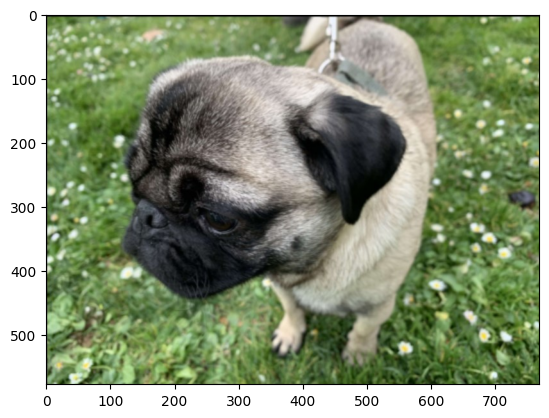

In [490]:
image = imread('gini_test.jpg')
plt.imshow(image);

In [491]:
image = np.array([cv2.resize(image, (32, 32))/255])

In [492]:
image.shape

(1, 32, 32, 3)

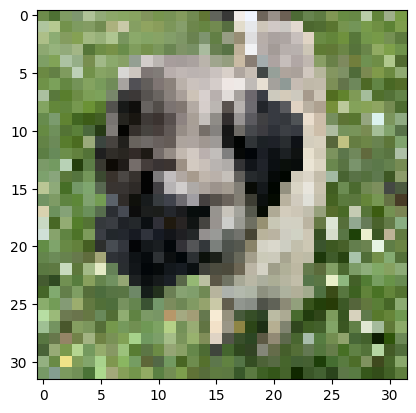

In [407]:
plt.imshow(image[0])

In [493]:
predictions = model.predict(image).round(3)
print("predictions shape:", predictions.shape)
predictions

1/1 [==============================] - 0s 144ms/step
predictions shape: (1, 1)


array([[1.]], dtype=float32)